# Get data

In [2]:
import requests
import zipfile
from pathlib import Path
import os
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image
import torchvision

# computer deep learning libraries
import torch
import torchvision
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1
0.14.1


In [4]:
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)


    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(requests.content)

    # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
            print("Unzipping pizza, steak, sushi data...") 
            zip_ref.extractall(image_path)



data/pizza_steak_sushi directory exists.


# Become one with data

In [5]:
# check how many images and folders are there by walking through the data
for dirpath, dirnames, filenames in os.walk(image_path, topdown=True):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"


#### Visualise Image


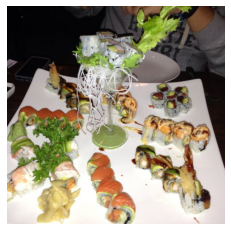

The shape of the image is (512, 512, 3)


In [7]:
torch.manual_seed(42)

# get all image paths
images_list = list(image_path.glob('*/*/*.jpg'))

# get a random path
random_image_path = random.choice(images_list)

# load the image
img = Image.open(random_image_path)

# convert the laoded image to numpyarray
np_array_image = np.asarray(img)

# plot the image 
plt.imshow(np_array_image)
plt.axis(False);
plt.show()

print(f"The shape of the image is {np_array_image.shape}")



# Transform Data

I've got folders of images but before I can use them with PyTorch, will need to convert them into tensors.

One of the ways to do this is by using the torchvision.transforms module.

torchvision.transforms contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation.

To get experience with torchvision.transforms, a series of transform steps that I would like to perform are:
<ul>
<li>Resize the images using transforms.Resize() (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).</li>
<li>Flip the images randomly on the horizontal using transforms.RandomHorizontalFlip() (this could be considered a form of data augmentation because it will artificially change our image data).</li>
<li>Turn  images from a PIL image to a PyTorch tensor using transforms.ToTensor().</li>
<li>I can compile all of these steps using torchvision.transforms.Compose().</li>
</ul>

In [8]:
data_transformations = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [9]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

# Data Loading 
Since this is a custom dataset, I need to load the data. 
<ul>There are 2 ways to do it
    <li>Load Images with Image Folder</li>
    <li>Load Images by writing a custom Class</li>
</ul>
Below I will do it using both options

### OPTION 1 : Load Images with Image Folder

In [10]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_transformations, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transformations)

In [11]:
# get class names and indexes
class_names = train_data.classes
class_dict = train_data.class_to_idx

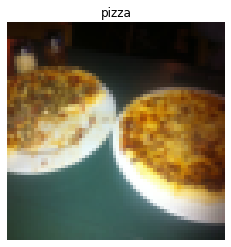

In [12]:
# Here the image is of dimension (C,H,W) to plot using matplot we need to change it to (H,W,C). 
# Cannot just queeze because squeeze can only remove all dimesnions of imput size 1. 
img, label = train_data[0]
img_permute = img.permute(1,2,0)
plt.imshow(img_permute)
plt.title(class_names[label])
plt.axis(False);
plt.show()

#### DataLoader

In [13]:
train_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, num_workers=1, shuffle=False)

### OPTION 2 : Load Images with Custom Dataset

Steps:
<ul>
<li>traverse the target directory using scandir to get the class names</li>
<li>raise error if class names are not found</li>
<li>turn class names into a data dictionary</li>
<li>Create custom dataset to replicate ImageFolder. Steps are as follows</li>
    <ul>
    <li>Subclass torch.utils.data.Dataset.</li>
    <li>Initialize our subclass with a targ_dir parameter (the target data directory) and transform parameter (so we have the option to transform our data if needed).</li>
    <li>Create several attributes for paths (the paths of our target images), transform (the transforms we might like to use, this can be None), classes and class_to_idx (from our find_classes() function).</li>
    <li>Create a function to load images from file and return them, this could be using PIL or torchvision.io (for input/output of vision data).</li>
    <li>Overwrite the __len__ method of torch.utils.data.Dataset to return the number of samples in the Dataset, this is recommended but not required. This is so you can call len(Dataset).</li>
    <li>Overwrite the __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required.</li>
    </ul>

</ul>

In [14]:
def find_classes(path:str):
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(path) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {path}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    
    return classes, class_to_idx

find_classes(path=train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [15]:
from torch.utils.data import Dataset
# Write a custom dataset
class FoodImageDatasetCustom(Dataset):
    def __init__(self, targ_dir:str, transform = None) -> None:
        self.paths = list(targ_dir.glob('*/*.jpg'))

        self.transform = transform

        self.classes, self.class_to_idx = find_classes(targ_dir)

    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self)-> int:
        return len(self.paths)
    
    def __getitem__(self, index: int):
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)
    


In [16]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [17]:
train_data_custom = FoodImageDatasetCustom(targ_dir=train_dir, transform=train_transforms)
test_data_custom = FoodImageDatasetCustom(targ_dir=test_dir, transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.FoodImageDatasetCustom at 0x14ef5beb0>,
 <__main__.FoodImageDatasetCustom at 0x14ef5baf0>)

In [18]:
# let's check the data
len(train_data_custom), len(test_data_custom)

(225, 75)

In [19]:
### check to see Dataset.ImageFolder vs CustomDataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)


True
True
True


# Create a function to display random images

In [20]:
def display_random_images(dataset:torch.utils.data.dataset.Dataset, n=10, classes=None, display_shape=True, seed=None):
    if seed:
        random.seed(seed)

    if n>10:
        n=10
        display_shape = False

    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(24, 10))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        adjusted_image = targ_image.permute(1,2,0)

        #plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(adjusted_image)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {adjusted_image.shape}"
        plt.title(title)






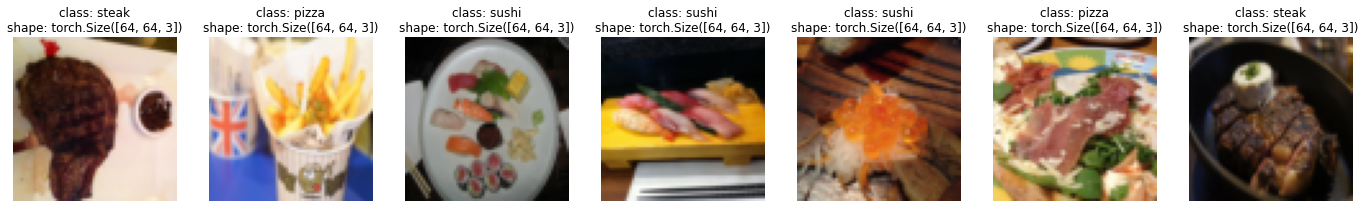

In [21]:
display_random_images(train_data, n =7, classes=class_names, seed=None)

In [22]:
# turn custom dataset into data loader
train_dataloader_custom = DataLoader(dataset=train_data_custom, batch_size=1, num_workers=0, shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=1, num_workers=0, shuffle=False)

In [23]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# Other Transformations

The purpose of transformations is to alter the images. This can be done through cropping, rotating, turning into tensors etc.

There are many transformations that are available to us. These transfromations when applied usually perform better than our randomly picked transformations that we plan on applying to the image

I replace horizontal flip with one of the transformation available to us in Pytorch hoping to get better results

***Note*** <br/>
I am not performing transformations on the test data because we try to generalise using the training data and then we do the predictions on the test data. Only transformation that needs to take place on the test data will be to convert it into a tensor.

In [24]:
train_transforms_updated = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense it needs to be , ranges from 0 to 31
    transforms.ToTensor()
])

test_transforms_updated = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

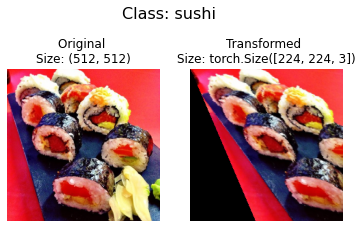

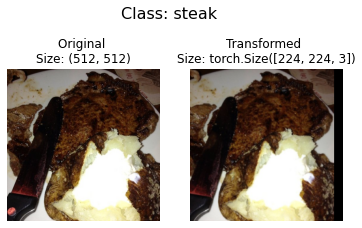

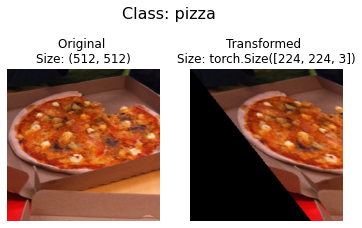

In [25]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms_updated,
    n=3,
    seed=None
)

# Model 0 - TinyVGG without Augumentation

In [26]:
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [27]:
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

In [28]:
train_dataloader_simple = DataLoader(dataset=train_data_simple, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=32, num_workers=os.cpu_count(), shuffle=True)

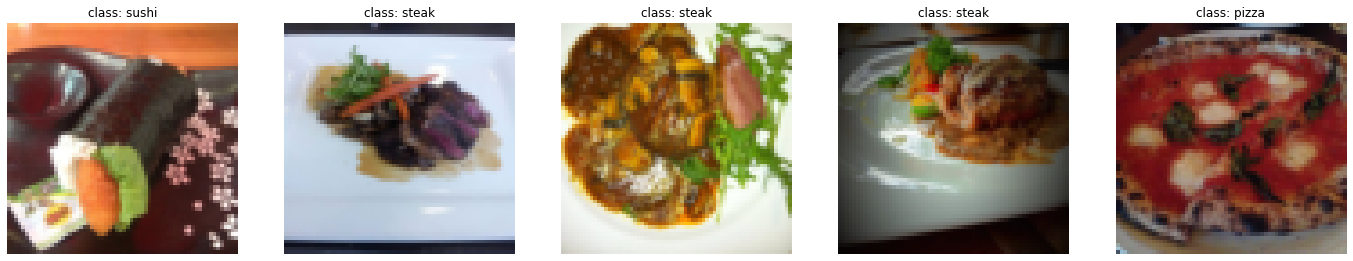

In [29]:
display_random_images(dataset=train_data_simple, n=5, display_shape=False, seed=None, classes=class_names)

In [30]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int) -> None:
        super().__init__()
        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )

    def forward(self, x):
        #print("before block 1 shape is ",x.shape)

        x = self.block1(x)
        #print("after block 1 shape is ",x.shape)

        x = self.block2(x)
        #print("after block 2 shape is ",x.shape)

        x = self.classifier(x)
        #print("after classifier shape is ",x.shape)

        return x


In [31]:
tinyVGG = TinyVGG(input_shape=3, hidden_units=100, output_shape= len(class_names))
loss_fn_simple = torch.nn.CrossEntropyLoss()
optim_simple = torch.optim.Adam(params=tinyVGG.parameters(), lr = 0.00001) 

In [32]:
# Get helper functions for plotting
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classe

helper_functions.py already exists, skipping download


In [33]:
# make functions for training testing and evaluation
def make_train(model:torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn:torch.nn.Module, optim:torch.optim.Optimizer, accuracy_fn = accuracy_fn):
    train_acc, train_loss = 0, 0
    model.train()
    for batch, (X,y) in enumerate(data_loader):
        train_logits = model.forward(X)

        train_pred = torch.argmax(train_logits, dim=1)

        loss = loss_fn(train_logits, y)
        train_loss += loss.item()

        train_acc += accuracy_fn(y_true=y, y_pred=train_pred)

        optim.zero_grad()

        loss.backward()

        optim.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print("train loss is ",train_loss,"train Acc is ", train_acc)

    return train_loss, train_acc

def make_test(model:torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn:torch.nn.Module, accuracy_fn = accuracy_fn):
    test_loss, test_acc = 0,0

    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loader):
            test_logits = model.forward(X)

            test_pred = torch.argmax(input=test_logits, dim=1)

            loss = loss_fn(test_logits, y)
            test_loss += loss.item()
            
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred)

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print("test loss is ",test_loss,"test Acc is ", test_acc)

        return test_loss, test_acc

def model_eval(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn:torch.nn.Module, accuracy_fn):

    loss , acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loader):
            y_logits = model(X)

            y_pred = torch.argmax(y_logits, dim=1)

            loss += loss_fn(y_logits, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred)

        loss /= len(data_loader)
        acc /= len(data_loader)



In [34]:
from tqdm.auto import tqdm
epochs = 5

# Create empty results dictionary
results = {"train_loss": [],
"train_acc": [],
"test_loss": [],
"test_acc": []
}

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = make_train(model=tinyVGG, data_loader=train_dataloader_simple, loss_fn=loss_fn_simple, optim=optim_simple, accuracy_fn=accuracy_fn)

    test_loss, test_acc = make_test(model=tinyVGG, data_loader=test_dataloader_simple, loss_fn=loss_fn_simple, accuracy_fn=accuracy_fn)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    

  0%|          | 0/5 [00:00<?, ?it/s]

train loss is  1.1007949262857437 train Acc is  30.46875
test loss is  1.1004927555720012 test Acc is  30.018939393939394
train loss is  1.100888192653656 train Acc is  30.46875
test loss is  1.097356915473938 test Acc is  33.996212121212125
train loss is  1.0948426127433777 train Acc is  42.578125
test loss is  1.0988715887069702 test Acc is  32.00757575757576
train loss is  1.0994235575199127 train Acc is  30.46875
test loss is  1.0980850060780842 test Acc is  33.996212121212125
train loss is  1.0983418226242065 train Acc is  30.46875
test loss is  1.0952543020248413 test Acc is  37.973484848484844


In [35]:
results

{'train_loss': [1.1007949262857437,
  1.100888192653656,
  1.0948426127433777,
  1.0994235575199127,
  1.0983418226242065],
 'train_acc': [30.46875, 30.46875, 42.578125, 30.46875, 30.46875],
 'test_loss': [1.1004927555720012,
  1.097356915473938,
  1.0988715887069702,
  1.0980850060780842,
  1.0952543020248413],
 'test_acc': [30.018939393939394,
  33.996212121212125,
  32.00757575757576,
  33.996212121212125,
  37.973484848484844]}

In [36]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

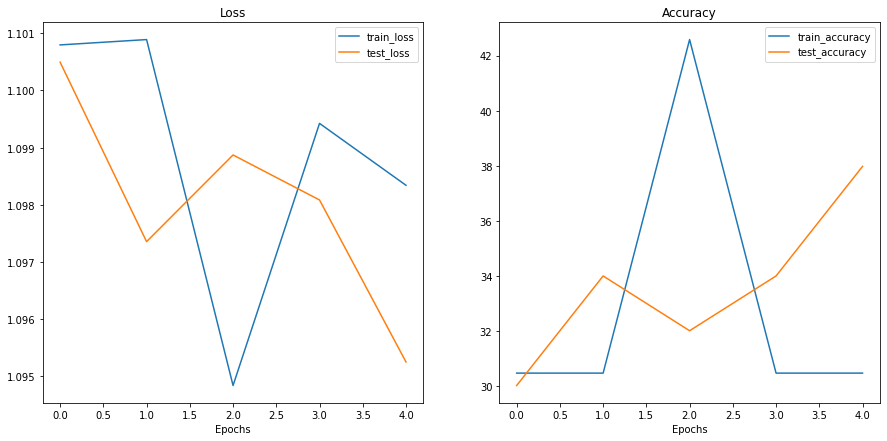

In [37]:
plot_loss_curves(results)

### The graphs show an erratic behaviour. This can mean multiple things
1. data too complex
2. Learning rate too high
3. Data is very noisy

These are only some reasons why this is happening. I will now try to redo the same model with data agumentations and see if there are any improvements.

# Model 1 - TinyVGG with Augumentations
I will now transform data using TrivialAugumentWide

In [38]:
transforms_trivial_augument = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

In [39]:
train_data_trivial_augument = datasets.ImageFolder(root=train_dir, transform= transforms_trivial_augument)
test_data_trivial_augument = datasets.ImageFolder(root=test_dir, transform= transforms_trivial_augument)

In [40]:
train_dataloader_trivial_augument = DataLoader(dataset=train_data_trivial_augument, num_workers=1, shuffle=True, batch_size=32)
test_dataloader_trivial_augument = DataLoader(dataset=test_data_trivial_augument, num_workers=1, shuffle=False, batch_size=32)

In [41]:
loss_fn_trivial_augument = torch.nn.CrossEntropyLoss()
optim_trivial_augument = torch.optim.Adam(params=tinyVGG.parameters(), lr=0.01)

In [42]:
epochs = 5

# Create empty results dictionary
results_2 = {"train_loss": [],
"train_acc": [],
"test_loss": [],
"test_acc": []
}

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = make_train(model=tinyVGG, data_loader=train_dataloader_trivial_augument, loss_fn=loss_fn_trivial_augument, optim=optim_trivial_augument, accuracy_fn=accuracy_fn)

    test_loss, test_acc = make_test(model=tinyVGG, data_loader=test_dataloader_trivial_augument, loss_fn=loss_fn_trivial_augument, accuracy_fn=accuracy_fn)

    results_2["train_loss"].append(train_loss)
    results_2["train_acc"].append(train_acc)
    results_2["test_loss"].append(test_loss)
    results_2["test_acc"].append(test_acc)


  0%|          | 0/5 [00:00<?, ?it/s]

train loss is  15.109940379858017 train Acc is  25.0
test loss is  1.100212534268697 test Acc is  26.041666666666668
train loss is  7.619907736778259 train Acc is  42.578125
test loss is  1.097914457321167 test Acc is  26.041666666666668
train loss is  1.1073014438152313 train Acc is  30.46875
test loss is  1.0977416435877483 test Acc is  26.041666666666668
train loss is  1.1006275117397308 train Acc is  30.859375
test loss is  1.1024430990219116 test Acc is  26.041666666666668
train loss is  1.097496747970581 train Acc is  30.46875
test loss is  1.1076141198476155 test Acc is  26.041666666666668


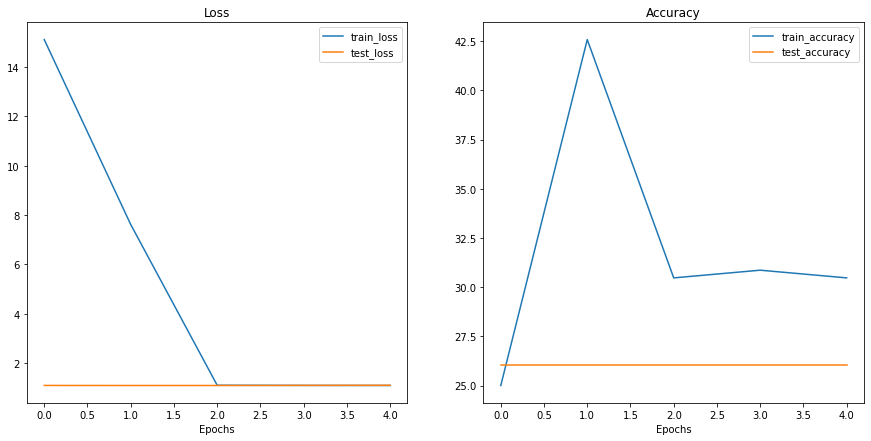

In [43]:
plot_loss_curves(results_2)

### I can observe that the model is still not doing so well. but the loss is reducing. 

#### <u>Method to prevent underfitting</u>

Method to prevent overfitting	What is it?
<Table>
<tr>
    <td>
    Get more data	
    </td>
    <td>
    Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.
    </td>
</tr>
<tr>
    <td>
    Simplify your model
    </td>
    <td>
    If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.
    </td>
</tr>
<tr>
    <td>
    Use data augmentation
    </td>
    <td>
	Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.
    </td>
</tr>
<tr>
    <td>
    Use transfer learning
    </td>	
    <td>
    Transfer learning involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.
    </td>
</tr>
<tr>
    <td>
    Use dropout layers
    </td>
    <td>
    Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See torch.nn.Dropout() for more.
    </td>
</tr>
<tr>
    <td>
    Use learning rate decay
    </td>
    <td>
    The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to convergence, the smaller you'll want your weight updates to be.
    </td>
<tr>
    <td>
    Use early stopping
    </td>
    <td>
        Early stopping stops model training before it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior).
    </td>
</tr>
<table>

#### <u>Method to prevent underfitting</u>

Method to prevent Underfitting	What is it?
<Table>
<tr>
    <td>
    Add more layers/units to your model	
    </td>
    <td>
    If your model is underfitting, it may not have enough capability to learn the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers.
    </td>
</tr>
<tr>
    <td>
    Tweak the learning rate
    </td>
    <td>
    Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens.
    </td>
</tr>
<tr>
    <td>
    Use transfer learning
    </td>
    <td>
	Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem.
    </td>
</tr>
<tr>
    <td>
    Train for longer
    </td>	
    <td>
    Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance.
    </td>
</tr>
<tr>
    <td>
    Use less regularization
    </td>
    <td>
    Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better.
    </td>
</tr>
<table>

In [44]:
import pandas as pd
df_model_0_results = pd.DataFrame(results)
df_model_1_results = pd.DataFrame(results_2)

In [45]:
df_model_1_results

,train_loss,train_acc,test_loss,test_acc
0,15.109940,25.000000,1.100213,26.041667
1,7.619908,42.578125,1.097914,26.041667
2,1.107301,30.468750,1.097742,26.041667
3,1.100628,30.859375,1.102443,26.041667
4,1.097497,30.468750,1.107614,26.041667


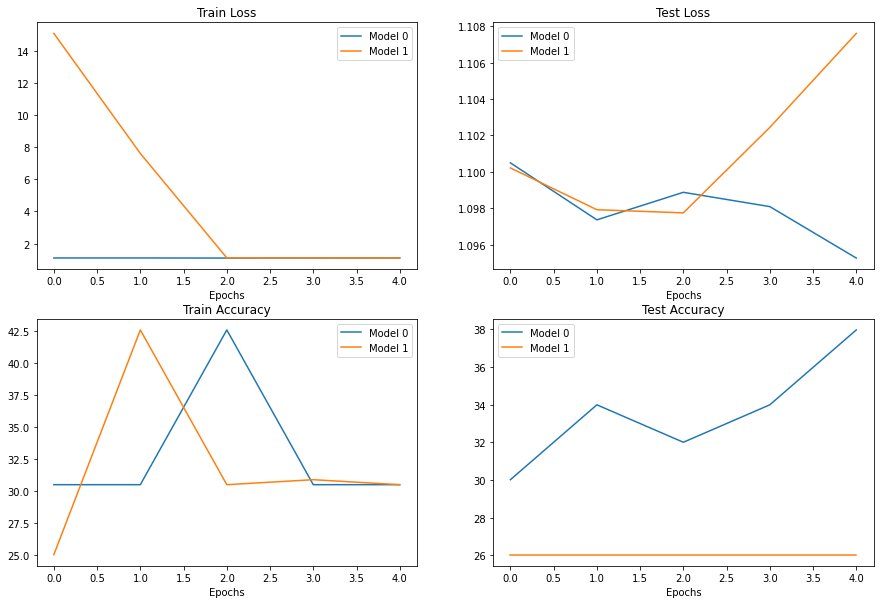

In [46]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(df_model_0_results))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, df_model_0_results["train_loss"], label="Model 0")
plt.plot(epochs, df_model_1_results["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, df_model_0_results["test_loss"], label="Model 0")
plt.plot(epochs, df_model_1_results["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, df_model_0_results["train_acc"], label="Model 0")
plt.plot(epochs, df_model_1_results["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, df_model_0_results["test_acc"], label="Model 0")
plt.plot(epochs, df_model_1_results["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

#### Both models are random guessing. I will first try to make a prediction and later see how we can improve the predictions

In [47]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data/04-pizza-dad.jpeg already exists, skipping download.


In [48]:
# load the data in the same format that the model was trained on and that is tensor form, shape (64,64)
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print("The custom image is of shape ", custom_image_uint8.shape)
print("The custom image is of type ", type(custom_image_uint8))
custom_image_float32 = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)



The custom image is of shape  torch.Size([3, 4032, 3024])
The custom image is of type  <class 'torch.Tensor'>


In [49]:
# if I am getting mat 1 and mat 2 cannot be multiplied then scale the values of the custom image and also use transforms to resize image
custom_image_float32 = custom_image_float32/255
print("The shape of custom image before transform is ", custom_image_float32.shape)
custom_image_transforms = transforms.Compose([transforms.Resize((64,64))])

# pass custom image through transformation 
custom_image_transformed = custom_image_transforms(custom_image_float32)
print("The shape of custom image after transform is ", custom_image_transformed.shape)

tinyVGG.eval()
with torch.inference_mode():
    prediction = tinyVGG.forward(custom_image_transformed.unsqueeze(0))


The shape of custom image before transform is  torch.Size([3, 4032, 3024])
The shape of custom image after transform is  torch.Size([3, 64, 64])


#### **To make predictions**
1. ensure the image is of same data type that model is trained on
2. ensure the image is of same input size that the model is trained on
3. ensure that the batch size is also appropriate



In [50]:
prediction

tensor([[ 0.0229,  0.0214, -0.0203]])

In [51]:
pred_label = torch.argmax(prediction,dim=1)


In [52]:
pred_label

tensor([0])

In [53]:
class_names[pred_label]

'pizza'

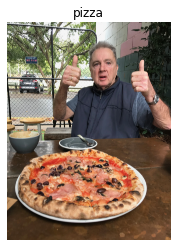

In [54]:
plt.imshow(custom_image_uint8.permute(1,2,0))
plt.title(class_names[pred_label])
plt.axis(False);

Even with random guessing the model is getting the right output, FUNNY! However, I would like to finetune the model to improve it's performance

# Transfer Learning 
I will now use transfer learning to train the model. According to literature by using weights of a pretrained model can provide better results. 
<p>I am planning to use a model trained on Imagenet to classify my food images. Benifits are as follows:
<li>Can leverage existing model architecture to directly work on our problem of my own</li>
<li>Can leverage a working model that has already learnt parrents aon similar data and hence can provide better resutls </li></p>

Find pretrained models here
<Table>
<th> Location</th><th> What's in it?</th> <th> Links</th>
<tr>
    <td>
    PyTorch domain libraries	
    </td>
    <td>
    Each of the PyTorch domain libraries (torchvision, torchtext) come with pretrained models of some form. The models there work right within PyTorch.
    </td>
    <td>
    torchvision.models, torchtext.models, torchaudio.models, torchrec.models
    </td>
</tr>
<tr>
    <td>
    HuggingFace Hub
    </td>
    <td>
    A series of pretrained models on many different domains (vision, text, audio and more) from organizations around the world. There's plenty of different datasets too.
    </td>
    <td>
    <a href>https://huggingface.co/models</a>, <a>https://huggingface.co/datasets</a>
    </td>
</tr>
<tr>
    <td>
    timm (PyTorch Image Models) library
    </td>
    <td>
	Almost all of the latest and greatest computer vision models in PyTorch code as well as plenty of other helpful computer vision features.
    </td>
    <td>
	<a>https://github.com/rwightman/pytorch-image-models</a>
    </td>
</tr>
<tr>
    <td>
    Paperswithcode
    </td>	
    <td>
    A collection of the latest state-of-the-art machine learning papers with code implementations attached. You can also find benchmarks here of model performance on different tasks.
    </td>
    <td>
    <a>https://paperswithcode.com/</a>
    </td>
    
</tr>
<table>

<p>Prior to torchvision 0.13+, to create a transform for a pretrained model in torchvision.models, the documetn stated:
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

I can use the following transform to normalize:

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) </p></br>

### Ways to transform Custom data going into model.
There are 2 ways to make (or) transform the custom image to be prepared in the same way as original training data went into the model
1. Manual method: use transforms.compose([]) -> use this while loading train data
2. auto method  : get model weights -> use weights.transforms() to get the transformation. use this to in while loading train data

In [55]:
# the above can be achieved by doing the following in method 1 - manual way
manual_transforms = transforms.Compose([
    transforms.Resize((223,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [56]:
train_data_transfer_learning_manual = datasets.ImageFolder(root=train_dir, transform=manual_transforms)
test_data_transfer_learning_manual = datasets.ImageFolder(root=test_dir, transform=manual_transforms)

class_names_manual = train_data_transfer_learning_manual.classes

In [57]:
train_dataloader_transfer_learning_manual = DataLoader(dataset=train_data_transfer_learning_manual, batch_size=32, num_workers=1, shuffle=True)
test_dataloader_transfer_learning_manual = DataLoader(dataset=test_data_transfer_learning_manual, batch_size=32, num_workers=1, shuffle=False)

In [58]:
train_dataloader_transfer_learning_manual, test_dataloader_transfer_learning_manual, class_names_manual

(<torch.utils.data.dataloader.DataLoader at 0x15291cfa0>,
 ['pizza', 'steak', 'sushi'])

In [59]:
# Method 2: automatic way, only works with pytorch version 0.13+
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights 

EfficientNet_B0_Weights.IMAGENET1K_V1

In [60]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [61]:
train_data_transfer_learning_auto = datasets.ImageFolder(root=train_dir, transform=auto_transforms)
test_data_transfer_learning_auto = datasets.ImageFolder(root=test_dir, transform=auto_transforms)

class_names_auto = train_data_transfer_learning_auto.classes

In [62]:
train_dataloader_transfer_learning_auto = DataLoader(dataset=train_data_transfer_learning_auto, batch_size=32, num_workers=1, shuffle=True)
test_dataloader_transfer_learning_auto = DataLoader(dataset=test_data_transfer_learning_auto, batch_size=32, num_workers=1, shuffle=False)

In [63]:
train_dataloader_transfer_learning_auto, test_dataloader_transfer_learning_auto , class_names_auto

(<torch.utils.data.dataloader.DataLoader at 0x15291c790>,
 ['pizza', 'steak', 'sushi'])

# Setting up the transfer learning model

In [64]:
#For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1
torchvision version: 0.14.1


In [65]:
print(torchvision.__version__)

0.14.1


In [66]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context # turning off SSL verification because I'm getting SSL error without this
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights)


In [67]:
# let me see what the model looks like
# it will have features, avgpool and classifier
# features- a collection of conv layers to learn base representation of data
# avgpool - takes the average of the output of the features and turns it into a feature vector
# classifier - turns feature vector into vector of same dimensionality as the number of required ouput classes.
model 

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [68]:
# pip3 install torchinfo
from torchinfo import summary

summary(model=model, input_size=(1,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"], 
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

#### I will Freeze base layers and change the classifier layer to match my problem statement which will output only 3 classes. 

This means changing the output nurons from 1000 to 3

In [69]:
for param in model.features.parameters():
    param.requires_grad = False # no longer track gradients during training. 

In [70]:
# update classifier to suit my use case - output will be 3 classes [sushi, pizza, steak]
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=3)
)

In [71]:
# now I can see the model is updated as per my requirements
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [72]:
# I will now build the model using the efficient net backbone
loss_transfer_learning = torch.nn.CrossEntropyLoss()
optim_transfer_learning = torch.optim.Adam(lr=0.001, params=model.parameters())
    

In [73]:
epochs = 5
torch.manual_seed(42)
# Create empty results dictionary
results_3 = {"train_loss": [],
"train_acc": [],
"test_loss": [],
"test_acc": []
}

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = make_train(model=model, data_loader=train_dataloader_transfer_learning_auto, loss_fn=loss_transfer_learning, optim=optim_transfer_learning, accuracy_fn=accuracy_fn)

    test_loss, test_acc = make_test(model=model, data_loader=test_dataloader_transfer_learning_auto, loss_fn=loss_transfer_learning, accuracy_fn=accuracy_fn)

    results_3["train_loss"].append(train_loss)
    results_3["train_acc"].append(train_acc)
    results_3["test_loss"].append(test_loss)
    results_3["test_acc"].append(test_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

train loss is  1.1299275681376457 train Acc is  34.765625
test loss is  0.9561935861905416 test Acc is  60.89015151515151
train loss is  0.9338165372610092 train Acc is  62.890625
test loss is  0.8685787916183472 test Acc is  67.23484848484848
train loss is  0.7640665397047997 train Acc is  87.109375
test loss is  0.6845688819885254 test Acc is  86.5530303030303
train loss is  0.7519066333770752 train Acc is  69.140625
test loss is  0.629413366317749 test Acc is  86.5530303030303
train loss is  0.6215835139155388 train Acc is  91.40625
test loss is  0.6417241096496582 test Acc is  82.57575757575758


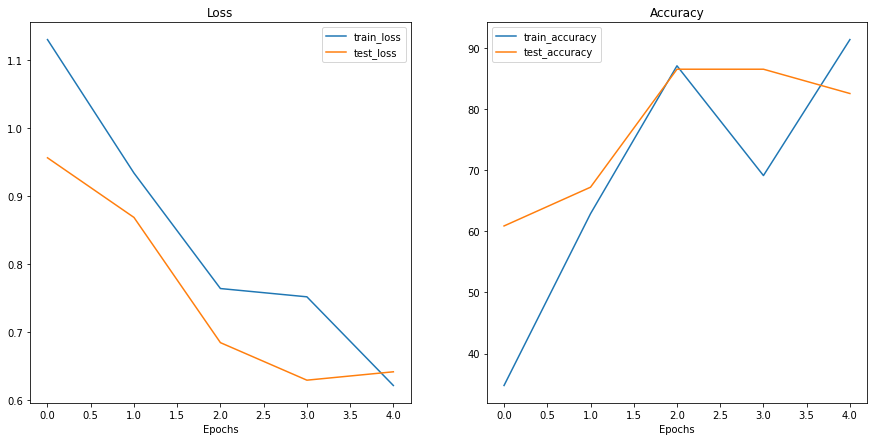

In [74]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results_3)

##### Now that Transfer learning is showing better accuracy compared to the previous models, I will make prediction using this model

In [75]:
def make_pred_and_plot(model: torch.nn.Module, image_path:str, class_names = None,  transform:torchvision.transforms = None):
    img = Image.open(image_path)

    if transform:
        image_transform = transform
    else:
        image_transform = torchvision.transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(0)

        logits = model.forward(transformed_image)

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(logits, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);


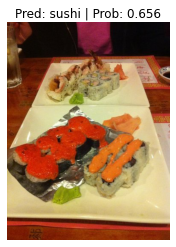

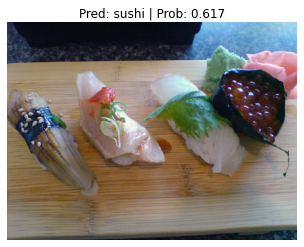

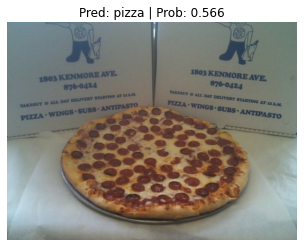

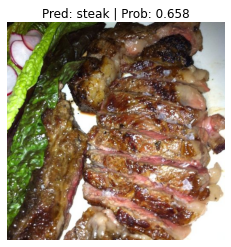

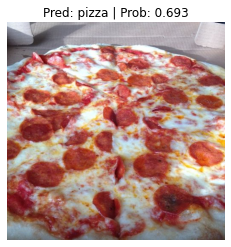

In [76]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 5
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    make_pred_and_plot(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        transform=weights.transforms()) # optionally pass in a specified transform from our pretrained model weights

#### Working very well!

data/04-pizza-dad.jpeg already exists, skipping download.


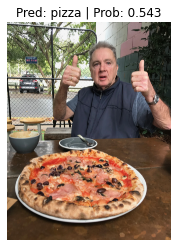

In [77]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
make_pred_and_plot(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

In [81]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for batch, (X, y) in tqdm(enumerate(test_dataloader_transfer_learning_auto, desc="Making predictions")):
    transformed_image = auto_transforms(X)

    logits = model.forward(transformed_image)
    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(logits, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Put predictions on CPU for evaluation
    y_preds.append(target_image_pred_label)

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

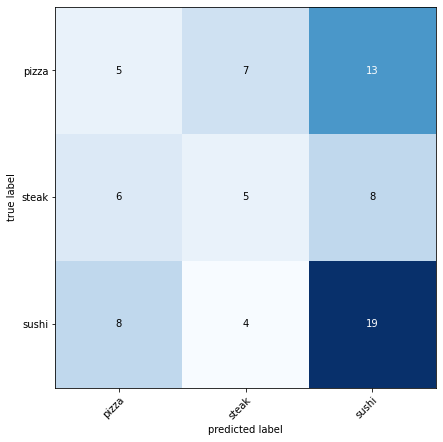

In [84]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Convert list of tensors to a single tensor because confusion matrix expects preds and targets to be tensors with dimensions.
y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.tensor(test_data.targets)

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=y_true_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

### We can observe that the loss curve is going down and accuracy is going up which is very good.

However, after seeing the confusion matrix I understand that more training data will definetly help the model learn better. Using transfer learning on the current is the better approach. 

For most of the problems in computervision, Transfer learning by first freezing the feature extractor layers and changing the classifier layers can help achieve great results. If the results are still not great then I can plan on fine tuning one layer at a time to see if that makes a difference.

For this notebook, on custom data of around 100 images each. Transfer learning using Efficient net architecture as backbone works well. 
